### Investigate max durations outliers in item and student attempt times
The duration between student start and stop times have large number of outliers of over 100 minutes

In [5]:
%run '../lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


You should consider upgrading via the '/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
filterDf = load_df('filterDf')
types = get_var_types()

###### Create dataframe of attempts with responses

In [3]:
durDf = select_attempts_with_responses(filterDf)
durDf.count()

64838

- 64,838

###### Impute null student start and stop dates

In [6]:
durDf = remove_749_to_750_null_dates(durDf)
durDf.count()

64401

- 64,401
  - 437 removed

###### Remove stop dates before start dates

In [9]:
durDf = remove_stop_dates_before_start_dates(durDf)
durDf.count()

64393

- 64,393
  - 8 removed

###### Add duration vars

In [10]:
durDf = add_attempt_duration(durDf)

###### Display problem

In [11]:
durDf.select(types['durationVars']).toPandas().describe()

,item_attempt_duration_mins,student_duration_mins,timeliness_duration_mins
count,64393.000000,64393.000000,62827.000000
mean,537.373847,1333.812447,19558.222651
std,3439.086979,6307.833932,25315.659349
min,0.000000,0.000000,-2751.200000
25%,0.450000,11.350000,2230.958333
50%,1.866667,27.900000,7781.166667
75%,9.750000,271.566667,27825.066667
max,109353.100000,261008.166667,144985.150000


- Max values over 100,000 above 3 quartile

###### Display histogram

In [39]:
pdDf = durDf.filter(F.col('item_attempt_duration_mins') < 200).select(types['durationVars']).toPandas()

<AxesSubplot:ylabel='Frequency'>

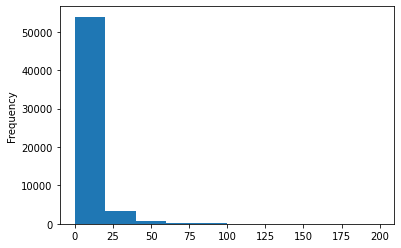

In [40]:
pdDf['item_attempt_duration_mins'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

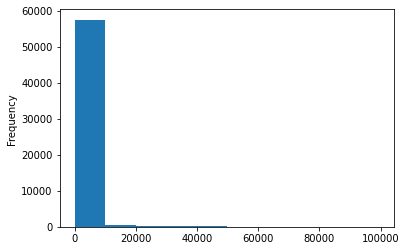

In [41]:
pdDf['student_duration_mins'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

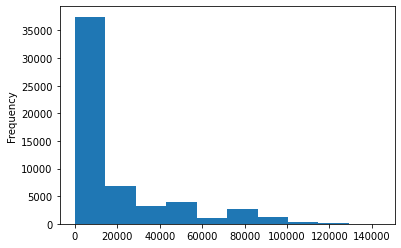

In [42]:
pdDf['timeliness_duration_mins'].plot.hist()

###### Created dataframe of student_duration greater than 100,000

In [19]:
stuDf = durDf.filter(F.col('student_duration_mins') > 500)
stuDf.count()

14542

- 40 values

###### Distinct values when student_duration greater than 100,000

In [20]:
distinct_val( stuDf )

,0
assigned_item_status (ia),scored
assignment_attempt_number (aa),1
assignment_max_attempts (a),1
is_manual_scoring_required (aa),False
item_is_offline_scored (i),False


- isolated to section 224713

###### View date statistics

In [21]:
dateStats = date_statisticts(stuDf, types['intervalVars'])
print ("Range", dateStats['min'].min(), "to", dateStats['max'].max())
dateStats

Range 2019-08-28 to 2020-06-05


,distinct,null,min,max
assignment_due_date,93,0,2019-08-29,2020-05-23
assignment_final_submission_date,101,0,2019-08-29,2020-06-05
assignment_start_date,123,0,2019-08-28,2020-05-04
item_attempt_end_datetime_utc,14540,0,2019-08-28,2020-05-20
item_attempt_start_datetime_utc,12801,0,2019-08-28,2020-05-20
max_student_stop_datetime,202,0,2019-08-29,2020-05-23
min_student_start_datetime,255,0,2019-08-28,2020-05-05
scored_datetime,920,570,2019-08-29,2020-05-23
student_start_datetime,1073,0,2019-08-28,2020-05-20
student_stop_datetime,905,0,2019-08-29,2020-05-23


- Due between 2019-11-22 and 2020-01-25
- Scored on 2020-04-13
- Conclusion:
  - 40 questions started but never finished
  - Teacher manually finished all on the same day
  - delete the observations

###### Delete student duration > 10000

In [17]:
durDf =  durDf.filter(F.col('student_duration_mins') < 100000)
durDf.count()

64353

- 40 values removed
  - 64,393 - 64,353

###### Check Progress

In [18]:
durDf.select(types['durationVars']).toPandas().describe()

,item_attempt_duration_mins,student_duration_mins,timeliness_duration_mins
count,64353.000000,64353.000000,62787.000000
mean,536.000710,1244.547432,19561.463931
std,3426.804087,5094.964543,25321.500553
min,0.000000,0.000000,-2751.200000
25%,0.450000,11.333333,2230.616667
50%,1.866667,27.900000,7780.283333
75%,9.766667,265.600000,27825.066667
max,109353.100000,99542.650000,144985.150000


- All max values decreased.


###### Correlation of high and low durations and zero score

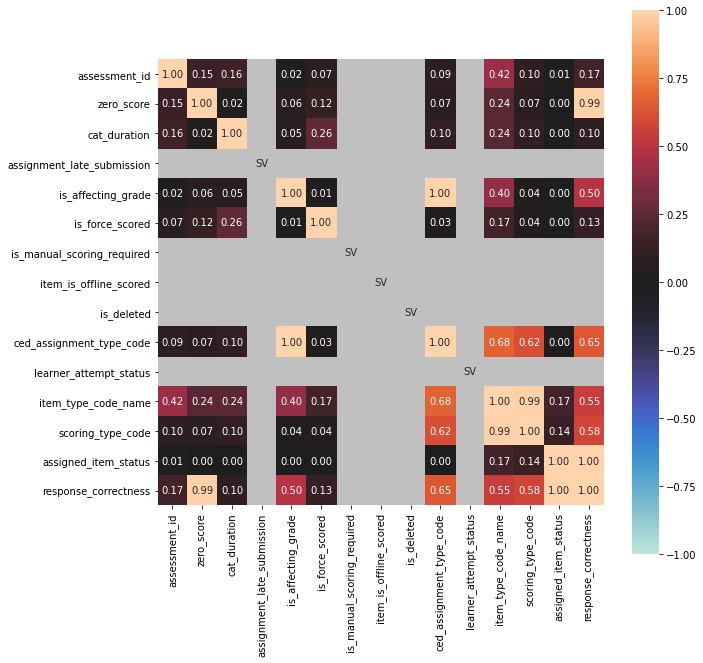

In [24]:
durDf = get_random_sample(durDf).withColumn(
    'cat_duration',
    F.when( F.col('student_duration_mins') > 100, 'High').otherwise('Low')
).withColumn(
    'zero_score',
    F.when( F.col('raw_score') == 0, 'Yes').otherwise('No')
)

corr, ax = associations( durDf.select('assessment_id', 'zero_score', 'cat_duration', *types['binaryVars'], *types['nominalVars']).toPandas(), nan_replace_value='null', figsize=[10,10] )

- No correlation to cat_duration

###### Preview an assessment with outliers

In [38]:
pdDf = get_random_sample(durDf).filter(F.col('student_duration_mins') > 5000).limit(5).toPandas()
pdDf

,ced_assignment_type_code,is_affecting_grade,number_of_learners,number_of_distinct_instance_items,assignment_max_attempts,assignment_late_submission,assignment_final_submission_date,assignment_start_date,assignment_due_date,min_student_start_datetime,...,assessment_instance_id,learner_assignment_attempt_id,assessment_instance_attempt_id,learner_id,learner_assigned_item_attempt_id,assessment_item_response_id,item_attempt_duration_mins,student_duration_mins,cat_duration,zero_score
0,assessment,True,25,16,1,False,2019-11-23 04:59:00,2019-11-05 05:00:00,2019-11-23 04:59:00,2019-11-07 16:58:07.752,...,587176,737176,820492,985418,1111458,1323471,5.366667,10033.133333,High,Yes
1,assessment,True,25,16,1,False,2019-11-23 04:59:00,2019-11-05 05:00:00,2019-11-23 04:59:00,2019-11-07 16:58:07.752,...,587176,737176,820492,985418,1111466,1237973,1.516667,10033.133333,High,No
2,assessment,True,27,26,1,False,2020-03-07 04:59:00,2020-02-18 13:00:00,2020-03-07 04:59:00,2020-02-20 13:10:12.807,...,553685,703188,874122,968745,1118598,1291837,24.400000,7196.233333,High,No
3,assessment,True,19,30,1,False,2020-03-06 16:17:00,2020-02-25 14:00:00,2020-03-06 16:17:00,2020-02-25 14:50:04.200,...,525739,675250,770557,972133,1123525,1331568,6911.483333,18514.850000,High,No
4,assessment,True,25,21,1,False,2019-11-09 05:59:00,2019-10-29 05:00:00,2019-11-09 05:59:00,2019-10-31 19:23:20.802,...,469908,619511,805465,1007205,1123866,1267834,5817.366667,5856.050000,High,No


In [42]:
ids = pdDf['assessment_instance_attempt_id'][3]
ids

770557

+------------------------+------------------+------------------+---------------------------------+-----------------------+--------------------------+--------------------------------+---------------------+-------------------+--------------------------+--------------------------+-------------------------+--------------------------+-----------------------------+--------------------------+---------------+--------------------------+--------------------------+--------------------------+----------------------+----------------------+--------------------------+----------------------+----------------------+-------------------+-----------------+---------+--------------------+-------------------------------+-----------------------------+--------------------+----------+------+----------+-------------+----------------------+-----------------------------+------------------------------+----------+--------------------------------+---------------------------+
|ced_assignment_type_code|is_affecting_grade

In [46]:
filterDf.filter( F.col('assessment_instance_attempt_id') == 770557).show(50, False)


+------------------------+------------------+------------------+---------------------------------+-----------------------+--------------------------+--------------------------------+---------------------+-------------------+--------------------------+-------------------------+-------------------------+-------------------------+-----------------------------+------------------------+---------------+--------------------------+-----------------------+----------------------+----------------------+----------------------+--------------------------+----------------------+-------------------+-------------------+-----------------+---------+--------------------+-------------------------------+-----------------------------+--------------------+----------+------+----------+-------------+----------------------+-----------------------------+------------------------------+----------+--------------------------------+---------------------------+
|ced_assignment_type_code|is_affecting_grade|number_of_lea

In [86]:
attDf = filterDf.filter( F.col('assessment_instance_attempt_id') == 770557)

In [87]:
attDf.filter(
       ( F.col('item_attempt_start_datetime_utc') <= F.col('item_attempt_end_datetime_utc') )
   ).show(100, False)

+------------------------+------------------+------------------+---------------------------------+-----------------------+--------------------------+--------------------------------+---------------------+-------------------+--------------------------+-------------------------+-------------------------+-------------------------+-----------------------------+------------------------+---------------+--------------------------+-----------------------+----------------------+----------------------+----------------------+--------------------------+----------------------+-------------------+-------------------+-----------------+---------+--------------------+-------------------------------+-----------------------------+--------------------+----------+------+----------+-------------+----------------------+-----------------------------+------------------------------+----------+--------------------------------+---------------------------+
|ced_assignment_type_code|is_affecting_grade|number_of_lea

In [88]:
remove_stop_dates_before_start_dates(filterDf).filter( F.col('assessment_instance_attempt_id') == 770557).show(50, False)

+------------------------+------------------+------------------+---------------------------------+-----------------------+--------------------------+--------------------------------+---------------------+-------------------+--------------------------+-------------------------+-------------------------+-------------------------+-----------------------------+------------------------+---------------+--------------------------+-----------------------+----------------------+----------------------+----------------------+--------------------------+----------------------+-------------------+-------------------+-----------------+---------+--------------------+-------------------------------+-----------------------------+--------------------+----------+------+----------+-------------+----------------------+-----------------------------+------------------------------+----------+--------------------------------+---------------------------+
|ced_assignment_type_code|is_affecting_grade|number_of_lea

In [51]:
durDf.filter( F.col('assessment_instance_attempt_id') == 770557).show(50, False)

+------------------------+------------------+------------------+---------------------------------+-----------------------+--------------------------+--------------------------------+---------------------+-------------------+--------------------------+-------------------------+-------------------------+-------------------------+-----------------------------+------------------------+---------------+--------------------------+-----------------------+----------------------+----------------------+----------------------+--------------------------+----------------------+-------------------+-------------------+-----------------+---------+--------------------+-------------------------------+-----------------------------+--------------------+----------+------+----------+-------------+----------------------+-----------------------------+------------------------------+----------+--------------------------------+---------------------------+--------------------------+---------------------+----------

In [ ]:
finish_todo('Investigate max durations outliers in item and student attempt times')
